In [2]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

from wordcloud import WordCloud
from tensorflow.keras import layers,models,losses, Sequential, optimizers, metrics


In [3]:
tweets_data = pd.read_csv('Tweets.csv')
tweets_data.sample(10)

,textID,text,selected_text,sentiment
8869,e0b4e991c1,"weird as usual, but ok... that`s why we like it",that`s why we like it,positive
25102,7feba445e5,Happy Mother`s Day to all the Ladies... With a...,Happy,positive
10962,924cbe3d0d,I`ve missed one this year(!). It`s the forbid...,Of all the trees in the garden I munch in disa...,negative
21236,385ba420d5,i`ve heard Basment Jaxx`s new song 'Raindrops'...,fantastic!!,positive
10929,eeb79d703e,Nobody does it better than www.traveljunky.com...,Not even half as good,negative
22002,36a30f20e3,"Oh let me clarify,know lots of nice people wh...","w lots of nice people who live there, but thou...",neutral
25716,31c12c99ad,collage. what is feminism?,collage. what is feminism?,neutral
20151,faa934e9a2,last day at Adobe buuuut I just registered fo...,last day at Adobe buuuut I just registered fo...,neutral
8464,eca4c46188,good evening. enjoying vacation eventhough it ...,good evening. enjoying vacation eventhough it ...,neutral
10901,9f0dffe575,"And how! It`s already been 1 year, it`ll be ...","d how! It`s already been 1 year, it`ll be WWD...",neutral


In [4]:
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [6]:
tweets_data= tweets_data.dropna()
tweets_data.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

In [7]:
tweets_data.duplicated().sum()

0

In [10]:
# tweets_data = tweets_data.drop(columns=["selected_text","textID"])
tweets_data.sample(10)

,text,sentiment
15829,I made this huge revelation as I was doing the...,negative
18076,Come on Vancouver. Throwing stuff onto the ice...,negative
1443,"_Twitster ohhhh, I love Morse, have every epis...",positive
15932,man i still haven`t seen that movie...too bad...,negative
4350,_OTTAWA have fun!,positive
3624,Any city person want to trade n live in the co...,neutral
25476,only got 22.90 in tips last night.. (N) but he...,neutral
26624,It SUCKS when my playmate is MIA all weekend. ...,negative
21392,is looking for a job,neutral
9993,your not in school,neutral


<AxesSubplot: xlabel='sentiment', ylabel='count'>

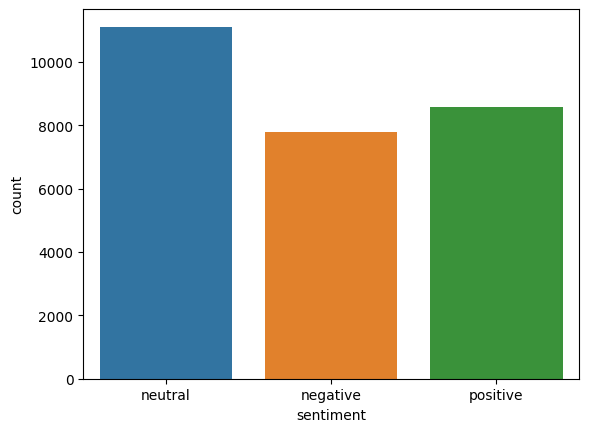

In [12]:
import seaborn as sns
sns.countplot(data=tweets_data,x="sentiment")

In [15]:
tweets_data["word_count"] = tweets_data["text"].apply(lambda x: len(str(x).split()))
tweets_data[["text", "word_count"]].sample(10)


,text,word_count
19506,_Dreaming what?! miley`s gonna quit hannah mon...,11
7168,So effing tired http://bit.ly/e0ZFz,4
22216,Up earlier because of a stupid orthadontist ap...,8
13233,hangover today,2
24622,And so very you. You know I say it w/ nothin...,14
23072,Work out. Now actual work,5
15016,Likewise. But I don`t know anyone who uses gt...,18
5683,"I am the empitome of epic fail, just you know,...",14
5121,Got moommy somn special for mothers day,7
20304,Can`t even tell you how much this hair dresser...,27


In [16]:
tweets_data.groupby("sentiment")["word_count"].mean()

sentiment
negative    13.473204
neutral     12.343888
positive    13.109881
Name: word_count, dtype: float64

<AxesSubplot: xlabel='word_count', ylabel='Count'>

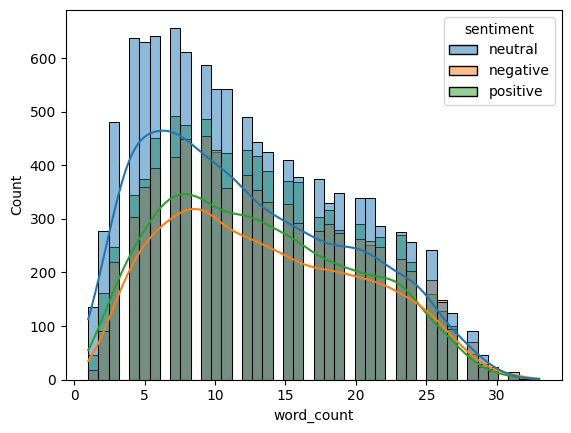

In [17]:
sns.histplot(data = tweets_data, x="word_count",hue="sentiment",kde= True)

In [22]:
from nltk.corpus import stopwords

nltk.download("stopwords")

stop_words = stopwords.words("english")

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
import string
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)

    stripped_urls = tf.strings.regex_replace(lowercase,r"https?://\S+|www\.S+","")
    

    stripped_symbol = tf.strings.regex_replace(stripped_urls,"\S+@\S+\s?","")

    stripped_brackets =tf.strings.regex_replace(stripped_symbol,"<.*?>+","")

    stripped_brackets =tf.strings.regex_replace(stripped_brackets,"\[|\]","")
    stripped_digits =tf.strings.regex_replace(stripped_brackets,"\w*\d\w*","")

    stripped_stopwords = tf.strings.regex_replace(stripped_digits,r"\b(?:{})\b".format("|".join(stop_words)),"")

    striped_whitespace_chars = tf.strings.regex_replace(stripped_stopwords,"\s+"," ")

    return tf.strings.regex_replace(striped_whitespace_chars,r"[^a-zA-Z\s]+","")

In [41]:
tweets_data["text"][11827]
custom_standardization(tweets_data["text"][11827]).numpy()

b' degree tear happy moment '

In [42]:
tweets_data["cleaned_text"]=tweets_data["text"].apply(custom_standardization)
tweets_data

,text,sentiment,word_count,cleaned_text
0,"I`d have responded, if I were going",neutral,7,"tf.Tensor(b' responded going', shape=(), dtyp..."
1,Sooo SAD I will miss you here in San Diego!!!,negative,10,"tf.Tensor(b' sooo sad miss san diego', shape=(..."
2,my boss is bullying me...,negative,5,"tf.Tensor(b' boss bullying ', shape=(), dtype=..."
3,what interview! leave me alone,negative,5,"tf.Tensor(b' interview leave alone', shape=(),..."
4,"Sons of ****, why couldn`t they put them on t...",negative,14,tf.Tensor(b' sons put releases already bough...
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,16,tf.Tensor(b' wish could come see u denver husb...
27477,I`ve wondered about rake to. The client has ...,negative,23,tf.Tensor(b' wondered rake client made clear...
27478,Yay good for both of you. Enjoy the break - y...,positive,22,tf.Tensor(b' yay good enjoy break probably n...
27479,But it was worth it ****.,positive,6,"tf.Tensor(b' worth ', shape=(), dtype=string)"


In [43]:
def tensor_to_string(tensor):
    return tensor.numpy().decode("utf-8")
tweets_data["cleaned_text"]= tweets_data["cleaned_text"].apply(tensor_to_string)
tweets_data


,text,sentiment,word_count,cleaned_text
0,"I`d have responded, if I were going",neutral,7,responded going
1,Sooo SAD I will miss you here in San Diego!!!,negative,10,sooo sad miss san diego
2,my boss is bullying me...,negative,5,boss bullying
3,what interview! leave me alone,negative,5,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,14,sons put releases already bought
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,16,wish could come see u denver husband lost job...
27477,I`ve wondered about rake to. The client has ...,negative,23,wondered rake client made clear net force...
27478,Yay good for both of you. Enjoy the break - y...,positive,22,yay good enjoy break probably need hectic w...
27479,But it was worth it ****.,positive,6,worth


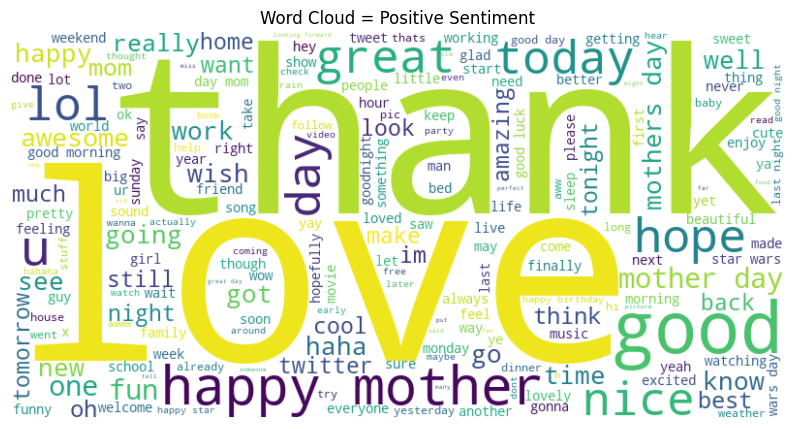

In [45]:
positive_tweets = tweets_data[tweets_data["sentiment"]=="positive"]["cleaned_text"]

positive_text=" ".join(positive_tweets)

wordcloud = WordCloud(width = 800,height = 400,background_color="white").generate(positive_text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud = Positive Sentiment")
plt.show()

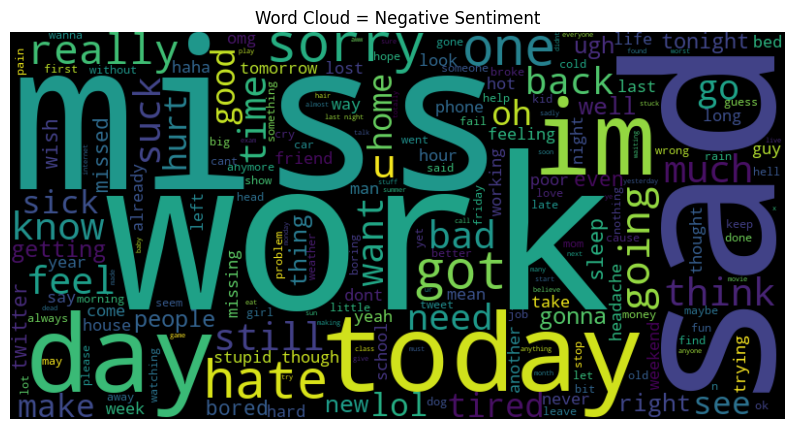

In [46]:
negative_tweets = tweets_data[tweets_data["sentiment"]=="negative"]["cleaned_text"]

negative_text=" ".join(negative_tweets)

wordcloud = WordCloud(width = 800,height = 400,background_color="black").generate(negative_text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud = Negative Sentiment")
plt.show()

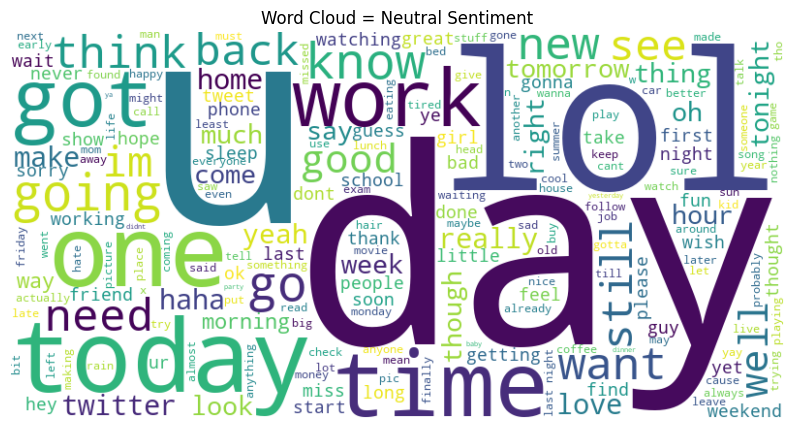

In [47]:
neutral_tweets = tweets_data[tweets_data["sentiment"]=="neutral"]["cleaned_text"]

neutral_text=" ".join(neutral_tweets)

wordcloud = WordCloud(width = 800,height = 400,background_color="white").generate(neutral_text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud = Neutral Sentiment")
plt.show()